In [1]:
import numpy as np
import Vanilla_CNN # import architecture file you wrote
import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from sklearn import metrics

# Construct dataset (MNIST)

In [2]:
root = '/Users/justinpyron/Machine-Learning/'
mnist_train = torchvision.datasets.MNIST(root, train=True, transform=torchvision.transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root, train=False, transform=torchvision.transforms.ToTensor())

subset_size = 10000
train_set = torch.utils.data.Subset(mnist_train, range(subset_size))
test_set = torch.utils.data.Subset(mnist_test, range(subset_size))


In [3]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=4)

test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=4)


# Construct model

In [4]:
input_shape = (1,28,28)
filter_list = [12,12,16]
maxpool_list = [0,0,0]
fc_list = [100, 50, 10]
Conv_to_FC_method = 'flatten'
dropout_prob = 0.4

model = Vanilla_CNN.CNN(input_shape,
                        filter_list,
                        maxpool_list,
                        fc_list,
                        Conv_to_FC_method,
                        dropout_prob)


# Train model

In [5]:
optimizer = optim.Adam(model.parameters(), weight_decay=1e-3)

num_epoch = 10
# Make containers to store results
train_accuracy_list = list()
test_accuracy_list = list()
train_metrics = list()
test_metrics = list()
start = time.time()

for epoch in range(num_epoch):

    # Train model
    # --------------
    model = model.train()
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(images)
        loss = F.nll_loss(output, labels)
        loss.backward()
        optimizer.step()
    
    # Evaluate model
    # --------------
    with torch.no_grad():
        model = model.eval()

        # Training set
        # ------------
        train_cm = np.zeros((10,10))
        for batch_idx, (images, labels) in enumerate(train_loader):
            output = model(images)
            pred = output.max(dim=1)[1]
            train_cm += metrics.confusion_matrix(y_true=labels,
                                                        y_pred=pred,
                                                        labels=range(10))
        train_accuracy_list.append(train_cm.diagonal().sum()/train_cm.sum())
        train_metrics.append(train_cm)

        # Test set
        # ------------
        test_cm = np.zeros((10,10))
        for batch_idx, (images, labels) in enumerate(test_loader):
            output = model(images)
            pred = output.max(dim=1)[1]
            test_cm += metrics.confusion_matrix(y_true=labels,
                                                       y_pred=pred,
                                                       labels=range(10))
        test_accuracy_list.append(test_cm.diagonal().sum()/test_cm.sum())
        test_metrics.append(test_cm)

        print('Epoch {} train accuracy: {:.3f}'.format(epoch, train_accuracy_list[-1]))
        print('Epoch {} test accuracy: {:.3f}'.format(epoch, test_accuracy_list[-1]))
        print('Time elapsed: {:.2f} minutes'.format((time.time()-start)/60.))
        print('\n')


Epoch 0 train accuracy: 0.889
Epoch 0 test accuracy: 0.882
Time elapsed: 1.60 minutes


Epoch 1 train accuracy: 0.921
Epoch 1 test accuracy: 0.919
Time elapsed: 3.17 minutes


Epoch 2 train accuracy: 0.942
Epoch 2 test accuracy: 0.939
Time elapsed: 4.81 minutes


Epoch 3 train accuracy: 0.958
Epoch 3 test accuracy: 0.947
Time elapsed: 6.43 minutes


Epoch 4 train accuracy: 0.953
Epoch 4 test accuracy: 0.949
Time elapsed: 8.04 minutes


Epoch 5 train accuracy: 0.962
Epoch 5 test accuracy: 0.957
Time elapsed: 9.65 minutes


Epoch 6 train accuracy: 0.963
Epoch 6 test accuracy: 0.958
Time elapsed: 11.26 minutes


Epoch 7 train accuracy: 0.971
Epoch 7 test accuracy: 0.959
Time elapsed: 12.88 minutes


Epoch 8 train accuracy: 0.964
Epoch 8 test accuracy: 0.952
Time elapsed: 14.51 minutes


Epoch 9 train accuracy: 0.969
Epoch 9 test accuracy: 0.957
Time elapsed: 16.13 minutes




In [6]:
def plot_confusion(cm, title, normalize=False):
    if normalize:
        cm = cm/cm.sum(axis=1)
    classes = range(10)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar(fraction=0.05)
    thresh = cm.max() / 2
    f = '.2f' if normalize else '.0f'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i,j] > 0:
                plt.text(j, i, format(cm[i, j], f),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot training results

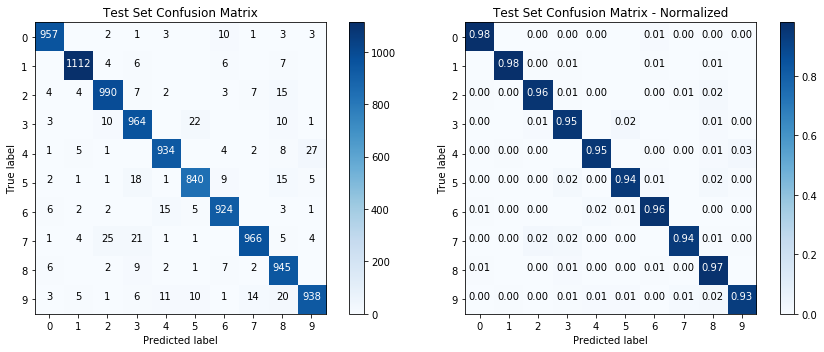

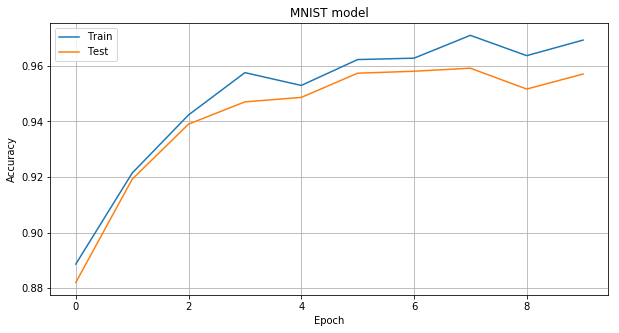

In [7]:
cm = test_metrics[-1]
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plot_confusion(cm, 'Test Set Confusion Matrix', False)
plt.subplot(1,2,2)
plot_confusion(cm, 'Test Set Confusion Matrix - Normalized', True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_accuracy_list, label='Train')
plt.plot(test_accuracy_list, label='Test')
plt.title('MNIST model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()